In [1]:
spark.version

'3.1.2'

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

1. Data loading

In [3]:
spark = SparkSession.builder.appName("mvp-prediction").getOrCreate()
print('spark session created')
data_path = 'gs://6893-data/player_stats_2020_2021.csv'
data = spark.read.format("csv").option("header", "true").option("inferschema", "true").load(data_path)
data.show(3)

spark session created


+--------------------+----------------+-----+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|                  id|            name|label|                reb|                ast|                stl|                blk|               tov|               pts|
+--------------------+----------------+-----+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|c377f6af-68b7-448...|Precious Achiuwa|    0| 3.4098360655737703|0.47540983606557374|0.32786885245901637|0.45901639344262296|0.7049180327868853| 4.983606557377049|
|9940444d-4c17-495...|    Jaylen Adams|    0|0.42857142857142855| 0.2857142857142857|                0.0|                0.0|               0.0|0.2857142857142857|
|c4141c57-acf4-42e...|    Steven Adams|    0|  8.862068965517242| 1.9137931034482758| 0.9310344827586207| 0.6551724137931034|1.3448275862068966| 7.551724137931035|
+---------------

In [4]:
data.printSchema()


root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- reb: double (nullable = true)
 |-- ast: double (nullable = true)
 |-- stl: double (nullable = true)
 |-- blk: double (nullable = true)
 |-- tov: double (nullable = true)
 |-- pts: double (nullable = true)



2. Data preprocessing

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [6]:
#stages in our Pipeline
stages = []

In [7]:
# Transform all features into a vector using VectorAssembler
numericCols = ["reb", "ast", "stl", "blk", "tov", "pts"]
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [8]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(data)
preppedDataDF = pipelineModel.transform(data)

In [9]:
preppedDataDF.take(3)

[Row(id='c377f6af-68b7-448b-96bc-755dde605e0b', name='Precious Achiuwa', label=0, reb=3.4098360655737703, ast=0.47540983606557374, stl=0.32786885245901637, blk=0.45901639344262296, tov=0.7049180327868853, pts=4.983606557377049, features=DenseVector([3.4098, 0.4754, 0.3279, 0.459, 0.7049, 4.9836])),
 Row(id='9940444d-4c17-495e-8bf5-1ab6b201c1fb', name='Jaylen Adams', label=0, reb=0.42857142857142855, ast=0.2857142857142857, stl=0.0, blk=0.0, tov=0.0, pts=0.2857142857142857, features=DenseVector([0.4286, 0.2857, 0.0, 0.0, 0.0, 0.2857])),
 Row(id='c4141c57-acf4-42eb-87e3-8ad7d47a2e91', name='Steven Adams', label=0, reb=8.862068965517242, ast=1.9137931034482758, stl=0.9310344827586207, blk=0.6551724137931034, tov=1.3448275862068966, pts=7.551724137931035, features=DenseVector([8.8621, 1.9138, 0.931, 0.6552, 1.3448, 7.5517]))]

In [11]:
# Keep relevant columns

cols = data.columns
selectedcols = ["features"] + cols
dataset = preppedDataDF.select(selectedcols)

display(dataset)

DataFrame[features: vector, id: string, name: string, label: int, reb: double, ast: double, stl: double, blk: double, tov: double, pts: double]

In [12]:
### Randomly split data into training and test sets. set seed for reproducibility
#=====your code here==========
trainingData, testData = dataset.randomSplit([.70, .30], seed=100)
#===============================
print(trainingData.count())
print(testData.count())

375
165


3. Modeling

In [13]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [14]:
# Fit model to prepped data

#LogisticRegression model, maxIter=10
#=====your code here==========
lrModel = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10).fit(trainingData)
#===============================

# select example rows to display.
predictions = lrModel.transform(testData)
predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
acc_hist = []
acc_hist.append(accuracy)

21/11/16 07:16:37 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/11/16 07:16:37 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
|            features|                  id|                name|label|                reb|                 ast|                 stl|                 blk|                 tov|                pts|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
| (6,[0,5],[1.0,4.0])|dd3b5400-348f-435...|       Udonis Haslem|    0|                1.0|                 0.0|                 0.0|                 0.0|                 0.0|                4.0|[8.93372565221176...|[0.99986815156428...|       0.0|
|[0.25,0

In [15]:
from pyspark.ml.classification import RandomForestClassifier
#Random Forest
#=====your code here==========
rfModel = RandomForestClassifier(featuresCol="features", labelCol="label").fit(trainingData)
#===============================

# select example rows to display.
predictions = rfModel.transform(testData)
predictions.show()

# compute accuracy on the test set
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
acc_hist.append(accuracy)

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+-----------+----------+
|            features|                  id|                name|label|                reb|                 ast|                 stl|                 blk|                 tov|                pts|rawPrediction|probability|prediction|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+-----------+----------+
| (6,[0,5],[1.0,4.0])|dd3b5400-348f-435...|       Udonis Haslem|    0|                1.0|                 0.0|                 0.0|                 0.0|                 0.0|                4.0|   [20.0,0.0]|  [1.0,0.0]|       0.0|
|[0.25,0.25,0.0,0....|a73539e0-e58c-4ac...|         Noah Vonleh|    0|  

In [16]:
#NaiveBayes
#=====your code here==========
from pyspark.ml.classification import NaiveBayes
nbModel = NaiveBayes(featuresCol="features", labelCol="label").fit(trainingData)

#===============================


# select example rows to display.
predictions = nbModel.transform(testData)
predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
acc_hist.append(accuracy)

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
|            features|                  id|                name|label|                reb|                 ast|                 stl|                 blk|                 tov|                pts|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
| (6,[0,5],[1.0,4.0])|dd3b5400-348f-435...|       Udonis Haslem|    0|                1.0|                 0.0|                 0.0|                 0.0|                 0.0|                4.0|[-4.0489478099639...|[0.97076225117282...|       0.0|
|[0.25,0

In [17]:
#Decision Tree
#=====your code here==========
from pyspark.ml.classification import DecisionTreeClassifier
dtModel = DecisionTreeClassifier(featuresCol="features", labelCol="label").fit(trainingData)

#===============================


# select example rows to display.
predictions = dtModel.transform(testData)
predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
acc_hist.append(accuracy)

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+-----------+----------+
|            features|                  id|                name|label|                reb|                 ast|                 stl|                 blk|                 tov|                pts|rawPrediction|probability|prediction|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+-----------+----------+
| (6,[0,5],[1.0,4.0])|dd3b5400-348f-435...|       Udonis Haslem|    0|                1.0|                 0.0|                 0.0|                 0.0|                 0.0|                4.0|  [349.0,0.0]|  [1.0,0.0]|       0.0|
|[0.25,0.25,0.0,0....|a73539e0-e58c-4ac...|         Noah Vonleh|    0|  

In [18]:
#Gradient Boosting Trees
#=====your code here==========
from pyspark.ml.classification import GBTClassifier
gbtModel = GBTClassifier(featuresCol="features", labelCol="label").fit(trainingData)

#===============================


# select example rows to display.
predictions = gbtModel.transform(testData)
predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
acc_hist.append(accuracy)

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
|            features|                  id|                name|label|                reb|                 ast|                 stl|                 blk|                 tov|                pts|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
| (6,[0,5],[1.0,4.0])|dd3b5400-348f-435...|       Udonis Haslem|    0|                1.0|                 0.0|                 0.0|                 0.0|                 0.0|                4.0|[1.54350200272498...|[0.95635347857270...|       0.0|
|[0.25,0

In [20]:
# Multi-layer Perceptron
#=====your code here==========
from pyspark.ml.classification import MultilayerPerceptronClassifier
mlpModel = MultilayerPerceptronClassifier(layers=[6, 5, 5, 2], seed=123, featuresCol="features", labelCol="label").fit(trainingData)

#===============================


# select example rows to display.
predictions = mlpModel.transform(testData)
predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
acc_hist.append(accuracy)

21/11/16 07:29:23 ERROR breeze.optimize.StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
21/11/16 07:29:23 ERROR breeze.optimize.StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
21/11/16 07:29:23 ERROR breeze.optimize.StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
21/11/16 07:29:23 ERROR breeze.optimize.StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
21/11/16 07:29:23 ERROR breeze.optimize.StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
21/11/16 07:29:23 ERROR breeze.optimize.StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
21/11/16 07:29:23 ERROR breeze.optimize.StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
21/11/16 07:29:23 ERROR breeze.

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
|            features|                  id|                name|label|                reb|                 ast|                 stl|                 blk|                 tov|                pts|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+----------+
| (6,[0,5],[1.0,4.0])|dd3b5400-348f-435...|       Udonis Haslem|    0|                1.0|                 0.0|                 0.0|                 0.0|                 0.0|                4.0|[331.783566261110...|[1.0,9.8776063048...|       0.0|
|[0.25,0

In [21]:
# Linear Support Vector Machine
#=====your code here==========
from pyspark.ml.classification import LinearSVC
svmModel = LinearSVC(maxIter=10, regParam=0.1).fit(trainingData)

#===============================


# select example rows to display.
predictions = svmModel.transform(testData)
predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
acc_hist.append(accuracy)

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------+
|            features|                  id|                name|label|                reb|                 ast|                 stl|                 blk|                 tov|                pts|       rawPrediction|prediction|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------+
| (6,[0,5],[1.0,4.0])|dd3b5400-348f-435...|       Udonis Haslem|    0|                1.0|                 0.0|                 0.0|                 0.0|                 0.0|                4.0|[1.09633152291551...|       0.0|
|[0.25,0.25,0.0,0....|a73539e0-e58c-4ac...|         Noah Vonleh|    0|               0.25|  

In [22]:
# One-vs-Rest
#=====your code here==========
from pyspark.ml.classification import LogisticRegression, OneVsRest
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
ovrModel = OneVsRest(classifier=lr).fit(trainingData)

#===============================


# select example rows to display.
predictions = ovrModel.transform(testData)
predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
acc_hist.append(accuracy)

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------+
|            features|                  id|                name|label|                reb|                 ast|                 stl|                 blk|                 tov|                pts|       rawPrediction|prediction|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------+
| (6,[0,5],[1.0,4.0])|dd3b5400-348f-435...|       Udonis Haslem|    0|                1.0|                 0.0|                 0.0|                 0.0|                 0.0|                4.0|[8.93372565221170...|       0.0|
|[0.25,0.25,0.0,0....|a73539e0-e58c-4ac...|         Noah Vonleh|    0|               0.25|  

In [23]:
print(len(acc_hist), acc_hist)

8 [0.9878787878787879, 0.9696969696969697, 0.9818181818181818, 0.9454545454545454, 0.9454545454545454, 0.9818181818181818, 0.9818181818181818, 0.9878787878787879]


In [24]:
models = ['lr', 'rf', 'nb', 'dt', 'GBT', 'MLP', 'LSVM', 'ovr']
results = dict(zip(models, acc_hist))
results = sorted(results.items(), key=lambda x: x[1])
print(results)

[('dt', 0.9454545454545454), ('GBT', 0.9454545454545454), ('rf', 0.9696969696969697), ('nb', 0.9818181818181818), ('MLP', 0.9818181818181818), ('LSVM', 0.9818181818181818), ('lr', 0.9878787878787879), ('ovr', 0.9878787878787879)]


In [25]:
accs = []
names = []
for i, t in enumerate(results):
    accs.append(results[i][1])
    names.append(results[i][0])
print(accs, names)

[0.9454545454545454, 0.9454545454545454, 0.9696969696969697, 0.9818181818181818, 0.9818181818181818, 0.9818181818181818, 0.9878787878787879, 0.9878787878787879] ['dt', 'GBT', 'rf', 'nb', 'MLP', 'LSVM', 'lr', 'ovr']


4. Comparison and analysis

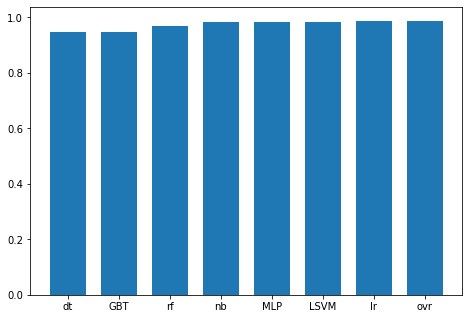

In [26]:
# Rank models according to Test set accuracy
#=====your code here==========
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(results)), accs, align='center', tick_label=names, width=0.7)
#plt.xticks(range(len(results)), list(results.keys()))
plt.show()
#===============================

*your analysis*
<br>
The accuracy is sorted in an ascending order.
<br>
mlp < naive bayes < Linear SVM < Random Forest < Decision Tree < One-vs-Rest < Linear Regression < GBT